In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from configuration import *
import pandas as pd

import spikeinterface.full as si

from spikeinterface.sortingcomponents.benchmark.benchmark_motion_interpolation import BenchmarkMotionInterpolationMearec

from figure_waveforms_distortion import plot_template_and_std, plot_distortion_distribution, plot_corrected_spike_locations
import spikeinterface.full as si

from plotting_tools import removeaxis, label_panel

Setting KILOSORT2_5_PATH environment variable for subprocess calls to: /home/samuel.garcia/Documents/SpikeInterface/code_sorters/Kilosort2.5


In [3]:
plt.rcParams.update({
    'font.size': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
})

In [4]:
figure_folder = base_folder / 'figures' / 'interpolation'
figure_folder.mkdir(exist_ok=True, parents=True)

extentions = ['png', 'pdf', 'tiff']

In [5]:
drift_cases = [
    ('uniform', 'homogeneous', 'rigid'),
    ('uniform', 'homogeneous', 'bumps'),
]


interpolation_methods = ['kriging', 'idw', 'nearest', ]
# interpolation_methods = ['kriging', ]

In [6]:
all_benchmarks = {}
for cells_position, cells_rate, drift_mode   in drift_cases:
    all_benchmarks[(cells_position, cells_rate, drift_mode)] = {}
    for interpolation_method in interpolation_methods:
        benchmark_folder = base_folder / 'bench_interpolation' / f'{probename}_{drift_mode}_{cells_position}_{cells_rate}' / f'{interpolation_method}'
        bench = BenchmarkMotionInterpolationMearec.load_from_folder(benchmark_folder)
        all_benchmarks[(cells_position, cells_rate, drift_mode)][interpolation_method] = bench

## waveforms distrotions on bumps

In [7]:
benchmarks_bumps = all_benchmarks[('uniform', 'homogeneous', 'bumps')]

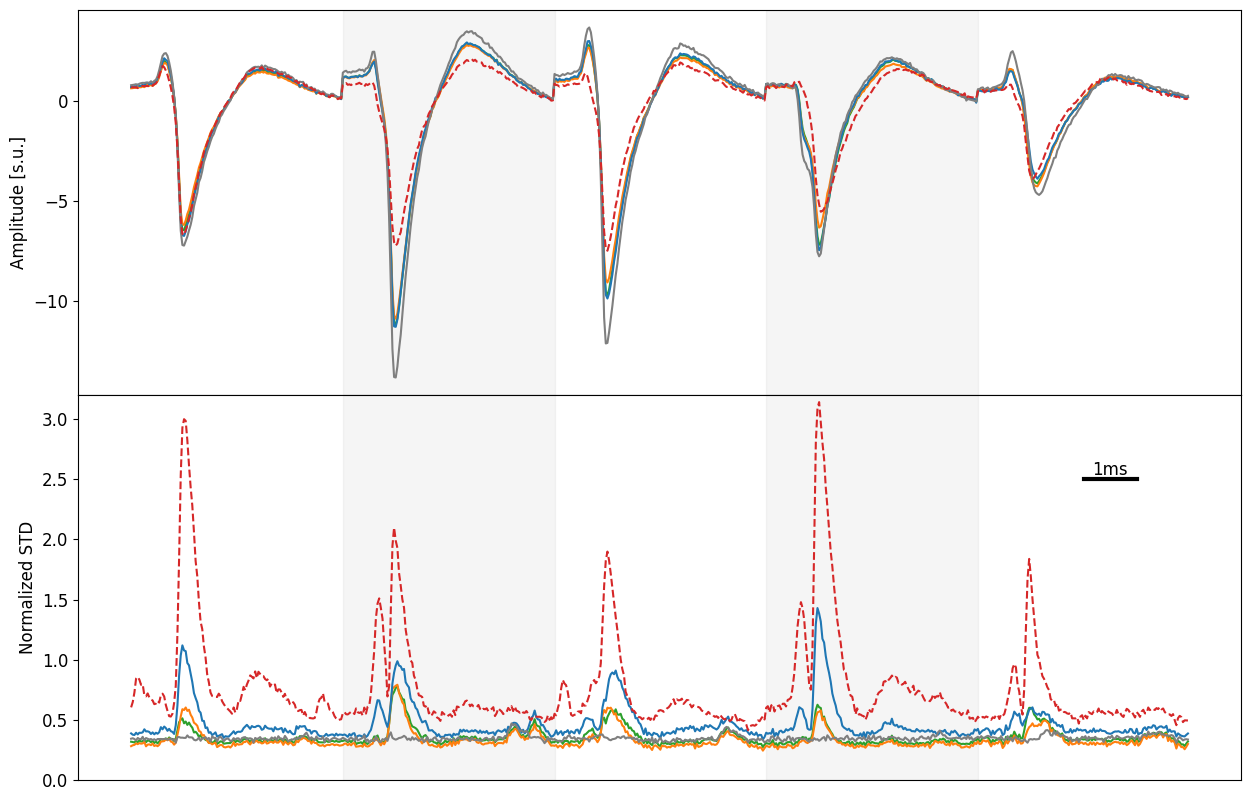

In [8]:
fig = plot_template_and_std(benchmarks_bumps, '#100')
for ext in extentions:
    fig.savefig(figure_folder / f'Figure6B_template_std.{ext}')

In [ ]:
for method, bench in benchmarks_bumps.items():
    bench.compute_distances_to_static(force=True)

static
drifting
corrected_gt
corrected_estimated
corrected_gt
corrected_estimated
corrected_gt
corrected_estimated


In [ ]:
fig = plot_distortion_distribution(benchmarks_bumps, metric='norm_std', bins=np.arange(0, 3, 0.04))
for ext in extentions:
    fig.savefig(figure_folder / f'Figure6C_distortion_distribution.{ext}')

## raster corrected on zigzag

In [ ]:
from spikeinterface.sortingcomponents.peak_detection import detect_peaks
from spikeinterface.sortingcomponents.peak_localization import localize_peaks
from spikeinterface.sortingcomponents.motion_interpolation import InterpolateMotionRecording

In [ ]:
benchmarks_rigid = all_benchmarks[('uniform', 'homogeneous', 'rigid')]

In [ ]:
# benchmarks = benchmarks_rigid
benchmarks = benchmarks_bumps
bench = next(iter(benchmarks.values()))

job_kwargs = dict(n_jobs=20, progress_bar=True, chunk_duration='1s')

detect_params = dict(
    # detect_threshold=12,
    # local_radius_um=150.,
    exclude_sweep_ms=0.1,
    radius_um=50,
    detect_threshold=10,
)

method ='monopolar_triangulation'
method_kwargs = dict(
    feature='peak_voltage',
    radius_um=75.
)

peaks_locations = {}


def preprocess(rec):
    rec = si.bandpass_filter(rec)
    rec = si.common_reference(rec)
    rec = si.zscore(rec)
    return rec
    

rec = preprocess(bench.recordings['raw_static'])
peaks = detect_peaks(rec, method='locally_exclusive', **detect_params, **job_kwargs)
locations = localize_peaks(rec, peaks, method=method, **method_kwargs, **job_kwargs)
peaks_locations['static'] = peaks, locations


rec = preprocess(bench.recordings['raw_drifting'])
peaks = detect_peaks(rec, method='locally_exclusive', **detect_params, **job_kwargs)
locations = localize_peaks(rec, peaks, method=method, **method_kwargs, **job_kwargs)
peaks_locations['drifting'] = peaks, locations


for interpolation_method, bench in benchmarks.items():
    # rec = bench.waveforms['corrected_gt'].recording
    rec = preprocess(bench.recordings['raw_drifting'])
    rec = InterpolateMotionRecording(rec, bench.gt_motion, bench.temporal_bins, bench.spatial_bins, **bench.correct_motion_kwargs)    
    
    peaks = detect_peaks(rec, method='locally_exclusive', **detect_params, **job_kwargs)
    locations = localize_peaks(rec, peaks, method=method, **method_kwargs, **job_kwargs)
    peaks_locations[interpolation_method] = peaks, locations

print(peaks_locations.keys())



In [ ]:
fig = plot_corrected_spike_locations(benchmarks_rigid, peaks_locations)

for ext in extentions:
    fig.savefig(figure_folder / f'Figure6A_corrected_spike_locations.{ext}')

## final figure

In [ ]:
figsize=(15,10)
fig = plt.figure(figsize=figsize)

gs0 = fig.add_gridspec(2, 5, wspace=0.1, hspace=1.0)
axes0 = [fig.add_subplot(gs0[0, i]) for i in range(5) ]

plot_corrected_spike_locations(benchmarks_rigid, peaks_locations,  axes=axes0)

for ax in axes0:
    ax.set_ylim(0, 400)


label_panel(axes0[0], 'A')


benchmarks = all_benchmarks[('uniform', 'homogeneous', 'bumps')]
gs1 = fig.add_gridspec(4, 6, wspace=2., hspace=0.0)
ax5 = fig.add_subplot(gs1[2, 0:3])
ax6 = fig.add_subplot(gs1[3, 0:3])

plot_template_and_std(benchmarks_bumps, '#100', axes=[ax5, ax6])
label_panel(ax5, 'B')
ax6.spines['bottom'].set_visible(False)

gs2 = fig.add_gridspec(2, 6, wspace=0., hspace=0.0)
ax7 = fig.add_subplot(gs2[1, 3:5])
ax8 = fig.add_subplot(gs2[1, 5])

plot_distortion_distribution(benchmarks_bumps, metric='norm_std', bins=np.arange(0, 3, 0.04), axes=[ax7, ax8])
label_panel(ax7, 'C')

for ax in axes0 + [ax5, ax6, ax7, ax8]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax8.spines['bottom'].set_visible(False)
ax8.set_xticks([])

for ext in extentions:
    fig.savefig(figure_folder / f'Figure6_distortion.{ext}')